In [32]:
import numpy as np
import pandas as pd

import os
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings("ignore")


In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [ ]:
!unzip /archive.zip -d /content/data
!ls /content/data


In [34]:
folder_training = "/content/data/archive/Training"

paths = []
labels = []

# Loop over each class folder (glioma, meningioma, etc.)
for img_class in os.listdir(folder_training):
    class_path = os.path.join(folder_training, img_class)

    # Make sure it's a directory
    if os.path.isdir(class_path):

        # Loop over images inside class folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            paths.append(img_path)
            labels.append(img_class)

# Create DataFrame
df_train = pd.DataFrame({
    "Img_Path": paths,
    "Img_Label": labels
})

print(df_train.head())
print("Total images:", len(df_train))

                                            Img_Path Img_Label
0  /content/data/archive/Training/glioma/Tr-gl_05...    glioma
1  /content/data/archive/Training/glioma/Tr-gl_08...    glioma
2  /content/data/archive/Training/glioma/Tr-gl_05...    glioma
3  /content/data/archive/Training/glioma/Tr-gl_06...    glioma
4  /content/data/archive/Training/glioma/Tr-gl_01...    glioma
Total images: 5712


In [35]:
folder_test = r"/content/data/archive/Testing"
Path = []
Labels = []

# To get the path for each image in the test set:

folders_path = os.listdir(folder_test)  # Use folder_test here
for img in folders_path:
    FolderPath = os.path.join(folder_test, img)  # Use folder_test here
    FolderName = os.listdir(FolderPath)
    for path in FolderName:
        Images_path = os.path.join(FolderPath, path)

        Path.append(Images_path)
        Labels.append(img)

# To create DataFrame
Pseries = pd.Series(Path, name = "Img_Path")
Lseries = pd.Series(Labels, name = "Img_label")
df_test = pd.concat([Pseries, Lseries], axis=1)

In [36]:
df_test

,Img_Path,Img_label
0,/content/data/archive/Testing/glioma/Te-gl_028...,glioma
1,/content/data/archive/Testing/glioma/Te-gl_022...,glioma
2,/content/data/archive/Testing/glioma/Te-gl_008...,glioma
3,/content/data/archive/Testing/glioma/Te-gl_017...,glioma
4,/content/data/archive/Testing/glioma/Te-gl_026...,glioma
...,...,...
1306,/content/data/archive/Testing/meningioma/Te-me...,meningioma
1307,/content/data/archive/Testing/meningioma/Te-me...,meningioma
1308,/content/data/archive/Testing/meningioma/Te-me...,meningioma
1309,/content/data/archive/Testing/meningioma/Te-me...,meningioma


In [37]:
valid_df, test_df=train_test_split(df_test, train_size=0.5, shuffle=True ,random_state=42)

In [38]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_generator = tr_gen.flow_from_dataframe(
    df_train,
    x_col='Img_Path',  # Use the correct column name for file paths
    y_col='Img_Label', # Use the correct column name for labels
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_generator = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='Img_Path',  # Use the correct column name for file paths
    y_col='Img_label', # Use the correct column name for labels
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_generator = ts_gen.flow_from_dataframe(
    test_df,
    x_col='Img_Path',  # Use the correct column name for file paths
    y_col='Img_label', # Use the correct column name for labels
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


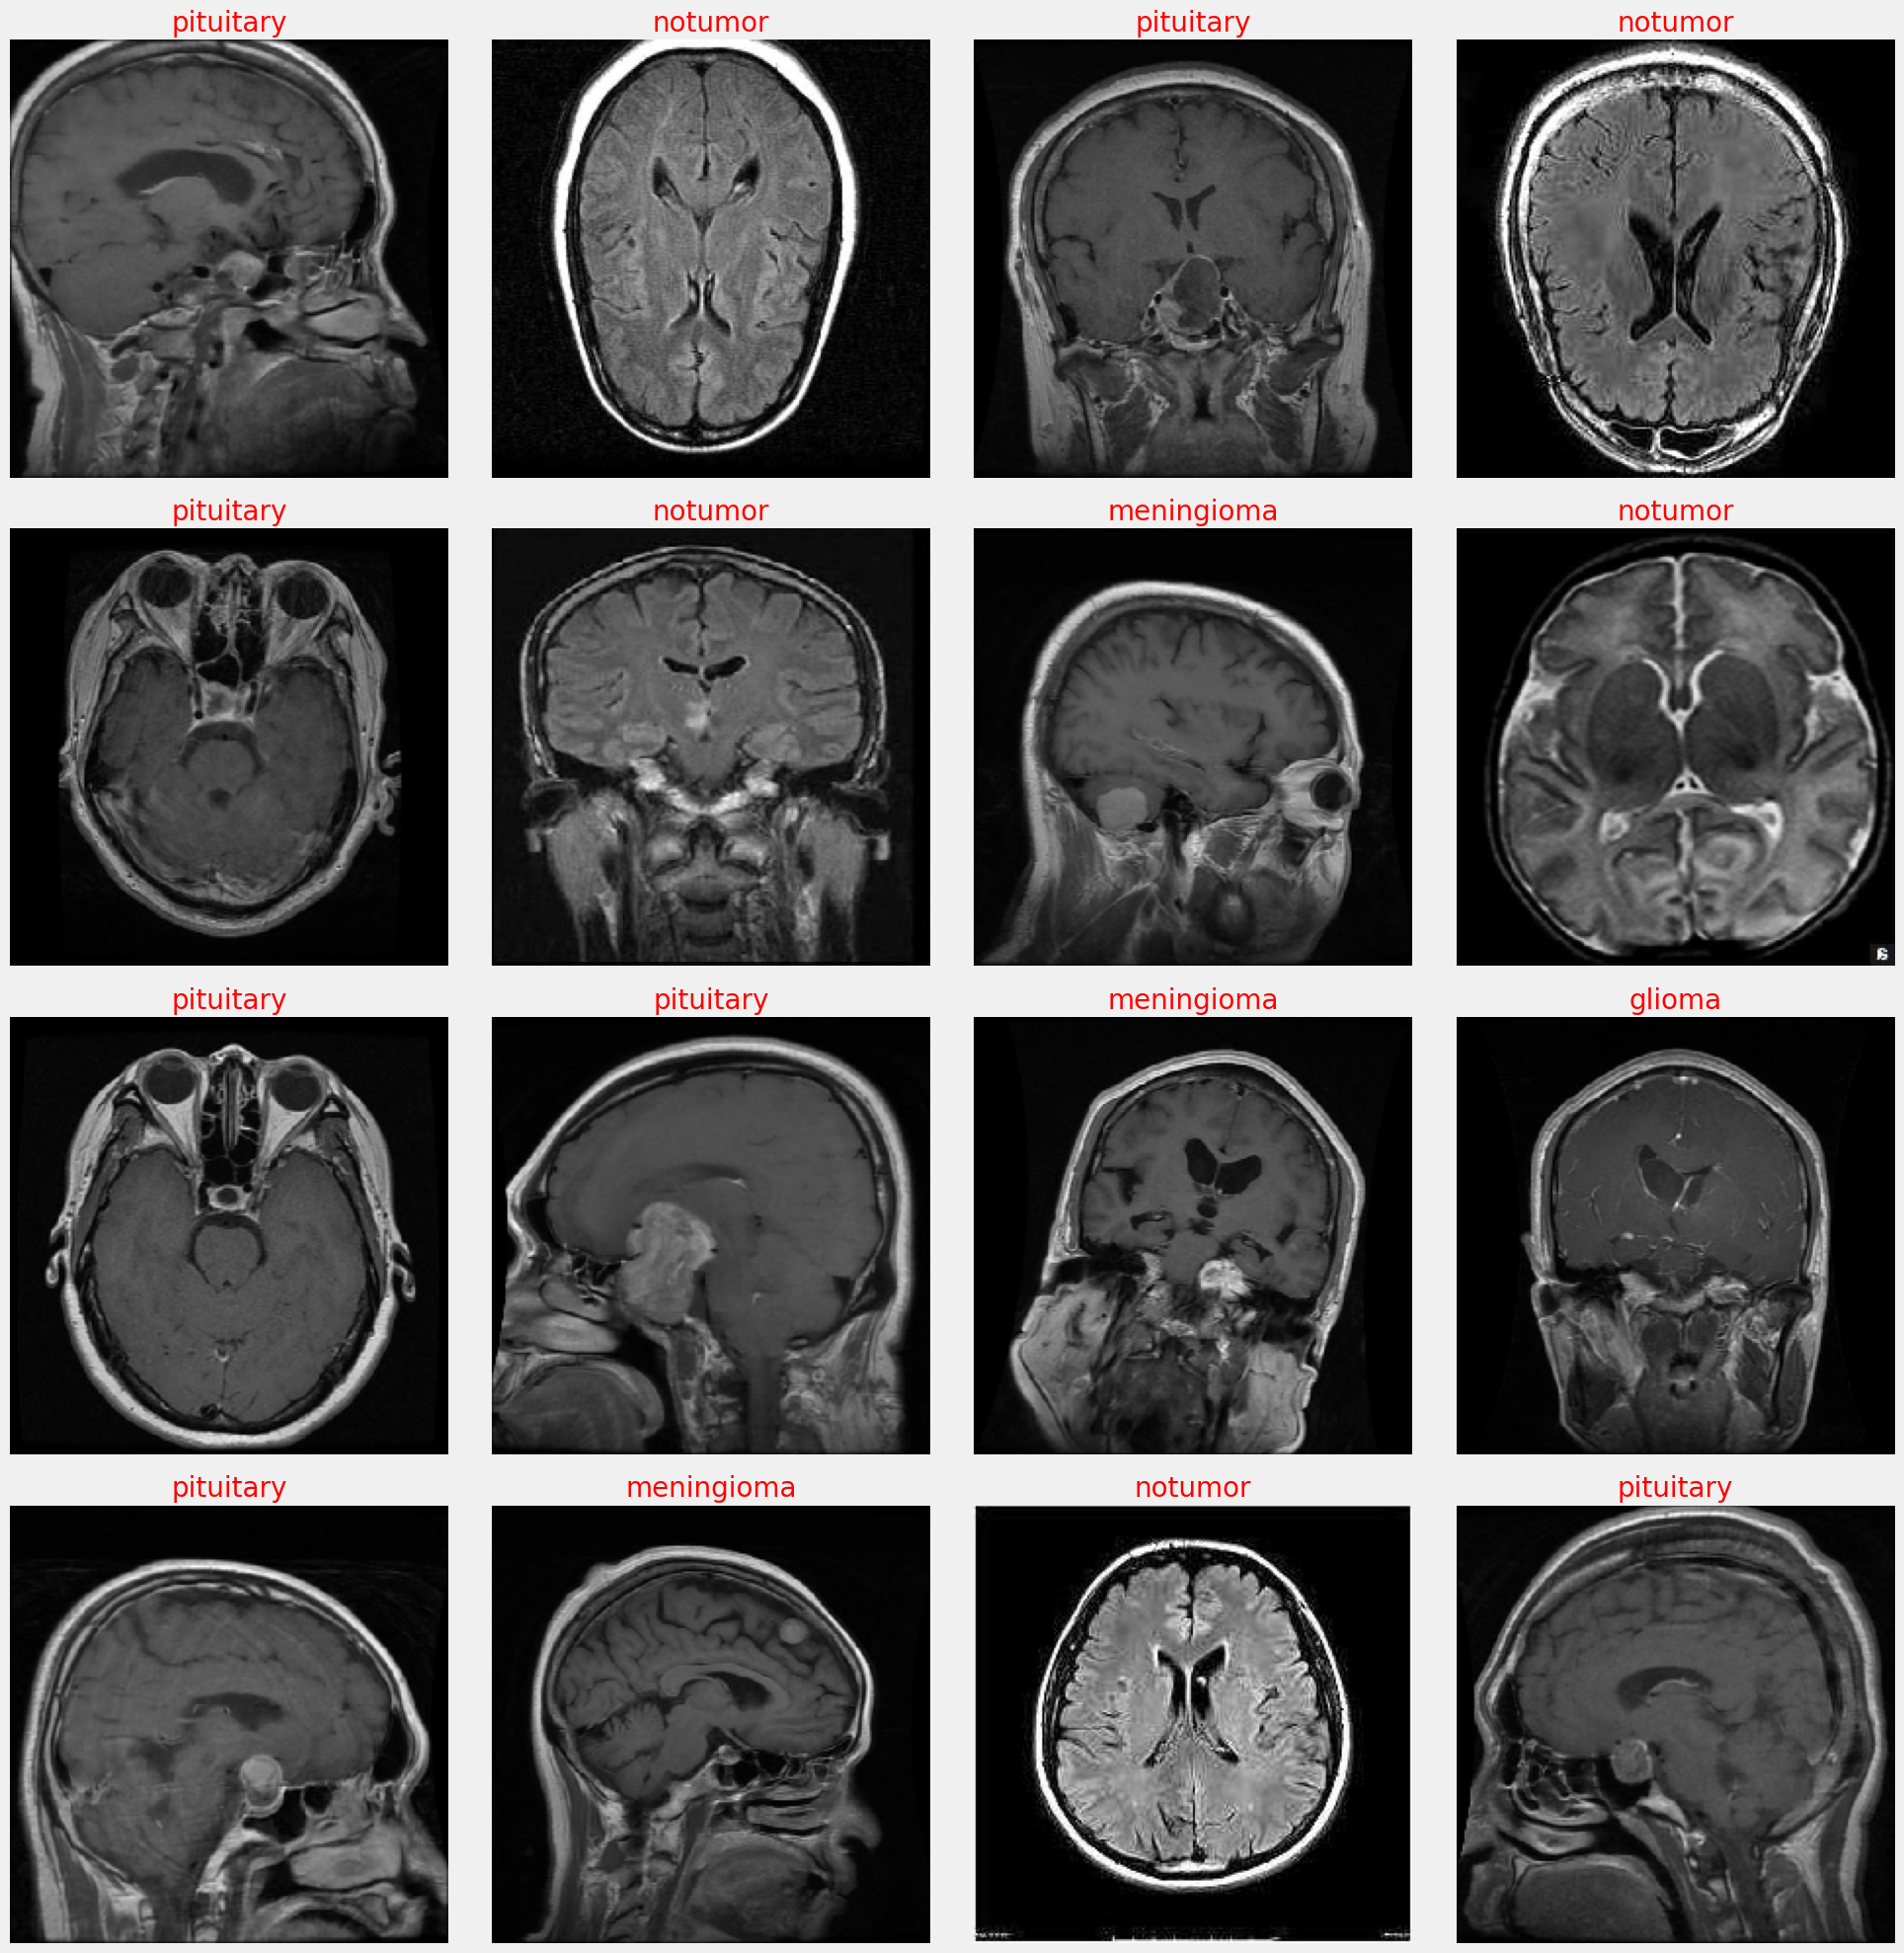

In [39]:
# Dictionary mapping class names to indices
gen_dict = train_generator.class_indices
# List of class names
classes = list(gen_dict.keys())

# Fetch a batch of images and labels
images, labels = next(train_generator)

# Set up the figure size
plt.figure(figsize=(20, 20))

# Loop through the first 20 images in the batch
for i in range(16):
    plt.subplot(4, 4, i + 1)

    # Normalize image pixel values to [0, 1] range
    image = images[i] / 255.0

    # Display the image
    plt.imshow(image)

    # Get the class index and class name
    index = np.argmax(labels[i])  # Get image index
    class_name = classes[index]   # Get class of image

    # Set the title with class name
    plt.title(class_name, color='red', fontsize=20)
    plt.axis('off')

# Adjust layout for better spacing between plots
plt.tight_layout()
# Display the plot
plt.show()

In [40]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_generator.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,154,180 (80.70 MB)

 Trainable params: 21,154,180 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs = 12   # number of all epochs in training

history = model.fit(train_generator, epochs= epochs, verbose= 1, validation_data= valid_generator, shuffle= False)

Epoch 1/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 148s 339ms/step - accuracy: 0.4589 - loss: 6.3513 - val_accuracy: 0.7282 - val_loss: 0.5954
Epoch 2/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 110s 309ms/step - accuracy: 0.8100 - loss: 0.4829 - val_accuracy: 0.7740 - val_loss: 0.5677
Epoch 3/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 111s 311ms/step - accuracy: 0.8610 - loss: 0.3703 - val_accuracy: 0.8382 - val_loss: 0.4594
Epoch 4/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 111s 312ms/step - accuracy: 0.9032 - loss: 0.2740 - val_accuracy: 0.8290 - val_loss: 0.4158
Epoch 5/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 112s 313ms/step - accuracy: 0.9189 - loss: 0.2283 - val_accuracy: 0.8763 - val_loss: 0.2501
Epoch 6/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 111s 312ms/step - accuracy: 0.9351 - loss: 0.1915 - val_accuracy: 0.9221 - val_loss: 0.2067
Epoch 7/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 112s 314ms/step - accuracy: 0.9431 - loss: 0.1527 - val_accuracy: 0.9160 - val_loss: 0.2272
Epoch 8/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 111s 312ms/step - accuracy: 0.9503 -

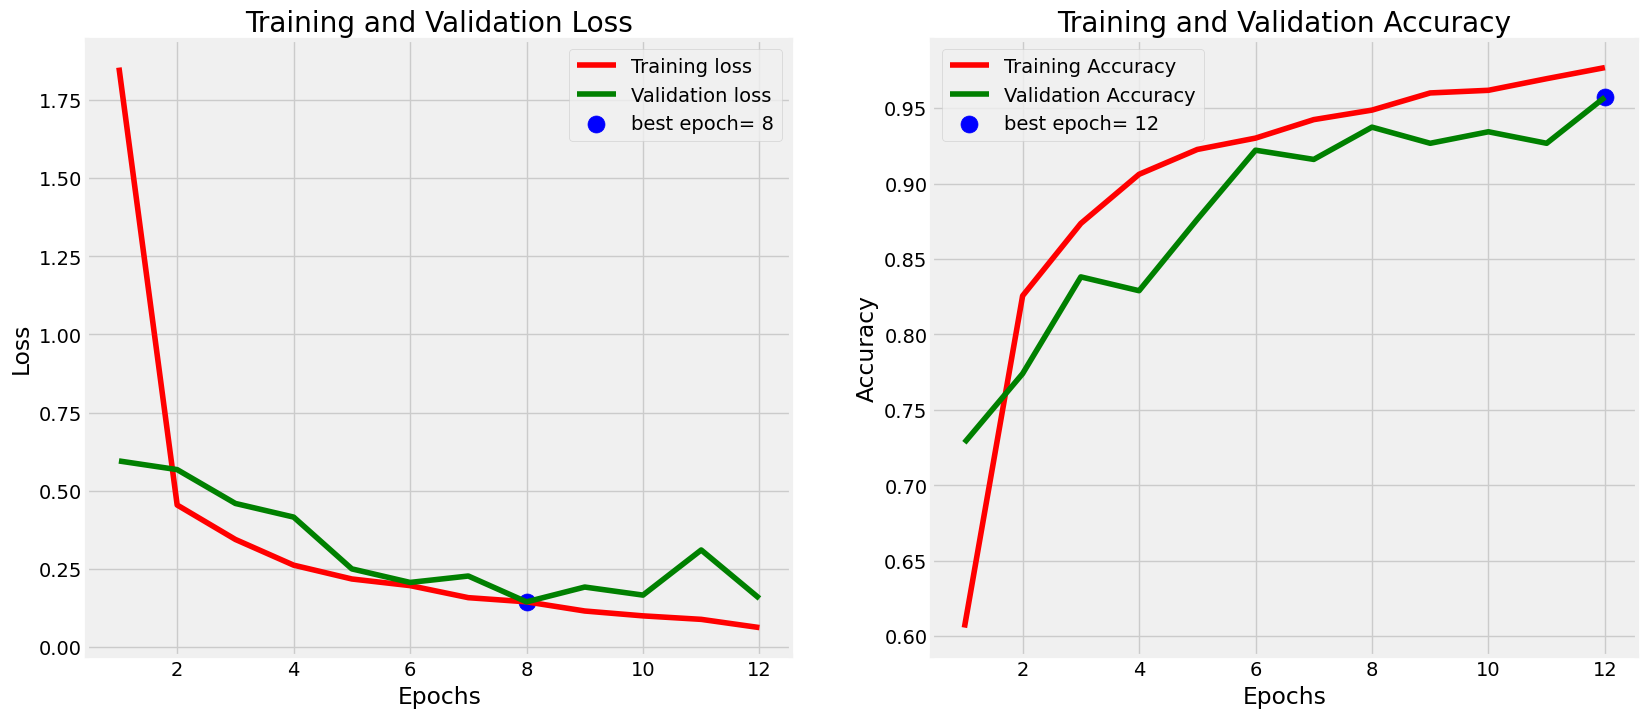

In [25]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [26]:
train_score = model.evaluate(train_generator, verbose= 1)
valid_score = model.evaluate(valid_generator, verbose= 1)
test_score = model.evaluate(test_generator, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.9819 - loss: 0.0575
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9576 - loss: 0.1486
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9395 - loss: 0.1842
Train Loss:  0.05478830263018608
Train Accuracy:  0.9821428656578064
--------------------
Validation Loss:  0.15547052025794983
Validation Accuracy:  0.9572519063949585
--------------------
Test Loss:  0.16852766275405884
Test Accuracy:  0.9435975551605225


In [27]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step


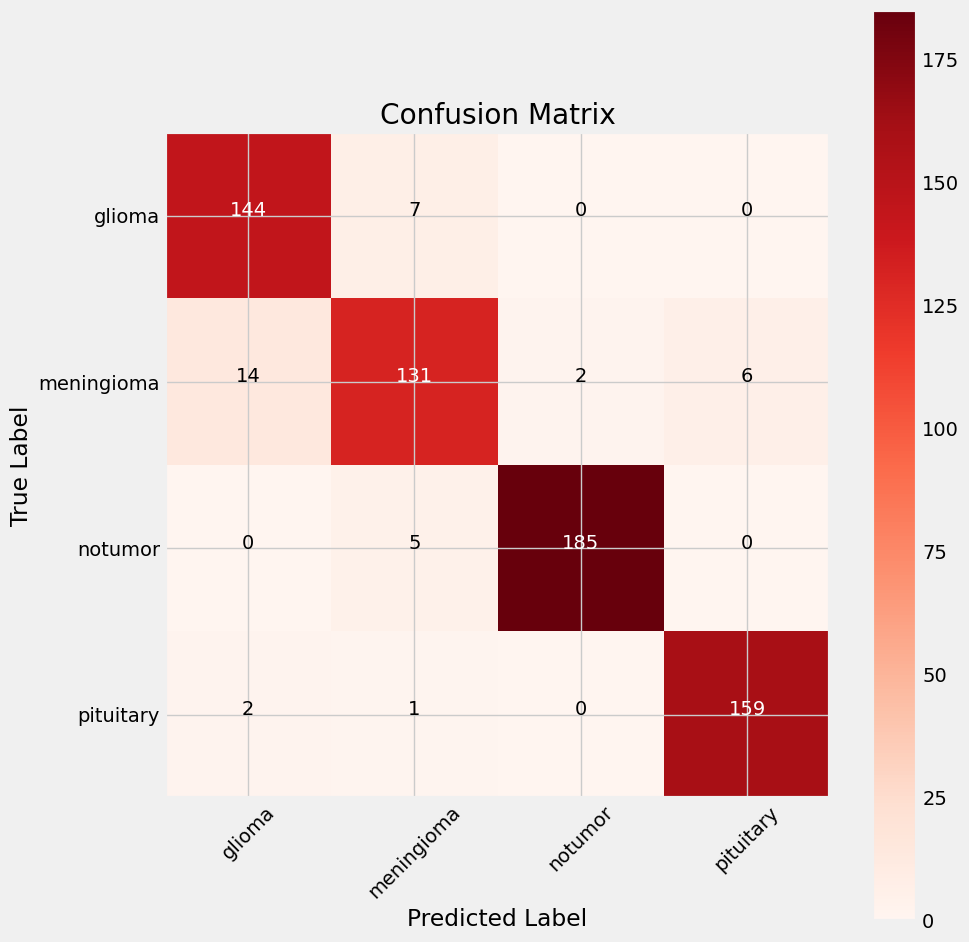

In [28]:
# Generate the class labels
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Compute the confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap='Reds')  # Use red colormap
plt.title('Confusion Matrix')
plt.colorbar()

# Set tick marks and labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [29]:
print(classification_report(test_generator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.90      0.95      0.93       151
  meningioma       0.91      0.86      0.88       153
     notumor       0.99      0.97      0.98       190
   pituitary       0.96      0.98      0.97       162

    accuracy                           0.94       656
   macro avg       0.94      0.94      0.94       656
weighted avg       0.94      0.94      0.94       656



In [30]:
#Save the model
model.save('Brain Tumors Classifier.h5')

In [42]:
from google.colab import files
files.download('/content/Brain Tumors Classifier.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>